In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [8]:
# Clearing the environment

try:
    del full_dataset, train_indices, val_indices, train_subset, val_subset, train_loader, val_loader, labels, class_names, model, criterion, optimizer
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Memory has been reset


In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import timm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Preparing the dataframe of file paths and labels

data_dir = ('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/')

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Walk through all subfolders and files
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            file_paths.append(os.path.join(subdir, file))
            labels.append(os.path.basename(subdir))
                
# Create a DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
data_df = data_df.sort_values(by='label', ascending=True)

# Display the DataFrame
print(data_df.head())
print(data_df.label.value_counts())

                                              file_path   label
2093  /kaggle/input/corn-or-maize-leaf-disease-datas...  Blight
1695  /kaggle/input/corn-or-maize-leaf-disease-datas...  Blight
1694  /kaggle/input/corn-or-maize-leaf-disease-datas...  Blight
1693  /kaggle/input/corn-or-maize-leaf-disease-datas...  Blight
1692  /kaggle/input/corn-or-maize-leaf-disease-datas...  Blight
label
Common_Rust       1306
Healthy           1162
Blight            1146
Gray_Leaf_Spot     574
Name: count, dtype: int64


In [3]:
# convert labels to integers

label_map = {label: idx for idx, label in enumerate(data_df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
data_df['label'] = data_df['label'].map(label_map)
print(data_df.head())
print(data_df.tail())

                                              file_path  label
2093  /kaggle/input/corn-or-maize-leaf-disease-datas...      0
1695  /kaggle/input/corn-or-maize-leaf-disease-datas...      0
1694  /kaggle/input/corn-or-maize-leaf-disease-datas...      0
1693  /kaggle/input/corn-or-maize-leaf-disease-datas...      0
1692  /kaggle/input/corn-or-maize-leaf-disease-datas...      0
                                              file_path  label
3410  /kaggle/input/corn-or-maize-leaf-disease-datas...      3
3409  /kaggle/input/corn-or-maize-leaf-disease-datas...      3
3408  /kaggle/input/corn-or-maize-leaf-disease-datas...      3
3388  /kaggle/input/corn-or-maize-leaf-disease-datas...      3
2707  /kaggle/input/corn-or-maize-leaf-disease-datas...      3


In [5]:
# Defining the dataset creator

from torch.utils.data import Dataset
from PIL import Image

class MaizeLeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(image_path).convert('RGB')
        
        label = self.dataframe.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # all requires 224px, except maxvit, mobilevitv2, darknet53, and edgenext, requiring 256px, inceptionv3, xception, and inceptionresnetv2, requiring 299px
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = MaizeLeafDataset(dataframe=data_df, transform=transform)

# Optional: extract labels and class names
labels = [label for _, label in full_dataset]

class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

train_indices, val_indices = train_test_split(np.arange(len(full_dataset)),test_size=0.2,stratify=labels,random_state=42)

train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4)

# Load pretrained Swin Transformer
import timm
model = timm.create_model('regnety_120', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# mobilenetv3_small_100, resnet50/101, efficientnet_b0, inception_resnet_v2, densenet121, inception_v3, xception41/65/71, regnety_032, darknet53, cspdarknet53, rexnet_200, edgenext_small, convnextv2_nano
# tiny_vit_5m_224, swin_tiny_patch4_window7_224, maxvit_nano_rw_256, coatnet_nano_rw_224, davit_tiny, resnetv2_50/101x1_bit, pvt_v2_b0/b1, mobilevitv2_200, convformer/caformer_s18, twins_svt/pcpvt_small, mvitv2_tiny, visformer_tiny/small, 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/208M [00:00<?, ?B/s]

In [8]:
# For tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_path = 'best_model.pth'

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]"
          f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%"
          f"  || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with val_acc: {val_acc:.2f}%")

Epoch [1/20]  Train Loss: 0.3213 | Train Acc: 88.27%  || Val Loss: 0.1940 | Val Acc: 92.24%
Saved new best model with val_acc: 92.24%
Epoch [2/20]  Train Loss: 0.1618 | Train Acc: 94.75%  || Val Loss: 0.1750 | Val Acc: 94.39%
Saved new best model with val_acc: 94.39%
Epoch [3/20]  Train Loss: 0.1405 | Train Acc: 95.13%  || Val Loss: 0.1706 | Val Acc: 93.32%
Epoch [4/20]  Train Loss: 0.0897 | Train Acc: 96.96%  || Val Loss: 0.1474 | Val Acc: 95.11%
Saved new best model with val_acc: 95.11%
Epoch [5/20]  Train Loss: 0.0809 | Train Acc: 96.99%  || Val Loss: 0.2306 | Val Acc: 93.44%
Epoch [6/20]  Train Loss: 0.0888 | Train Acc: 96.78%  || Val Loss: 0.1790 | Val Acc: 95.11%
Epoch [7/20]  Train Loss: 0.0904 | Train Acc: 96.81%  || Val Loss: 0.2067 | Val Acc: 94.87%
Epoch [8/20]  Train Loss: 0.0695 | Train Acc: 97.73%  || Val Loss: 0.2116 | Val Acc: 94.51%
Epoch [9/20]  Train Loss: 0.0584 | Train Acc: 97.97%  || Val Loss: 0.2141 | Val Acc: 93.68%
Epoch [10/20]  Train Loss: 0.0516 | Train Acc:

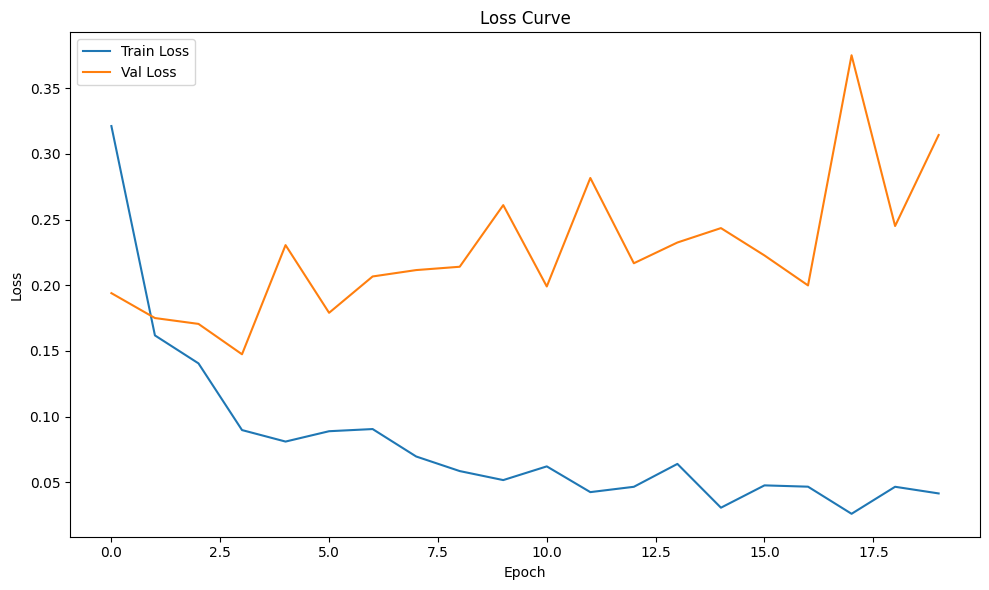

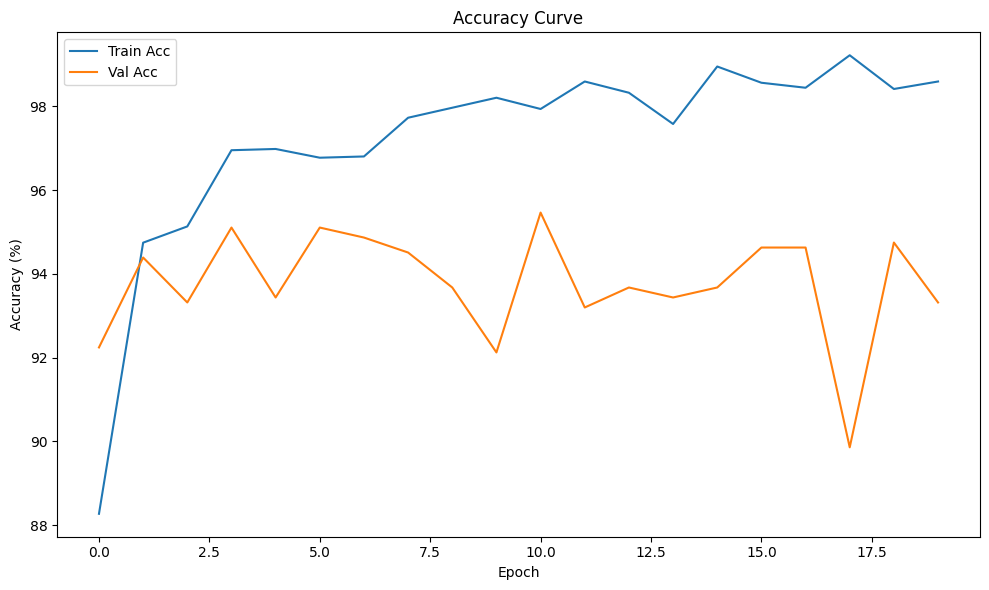

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Loss and Accuracy
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('Loss.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.savefig('Acc.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

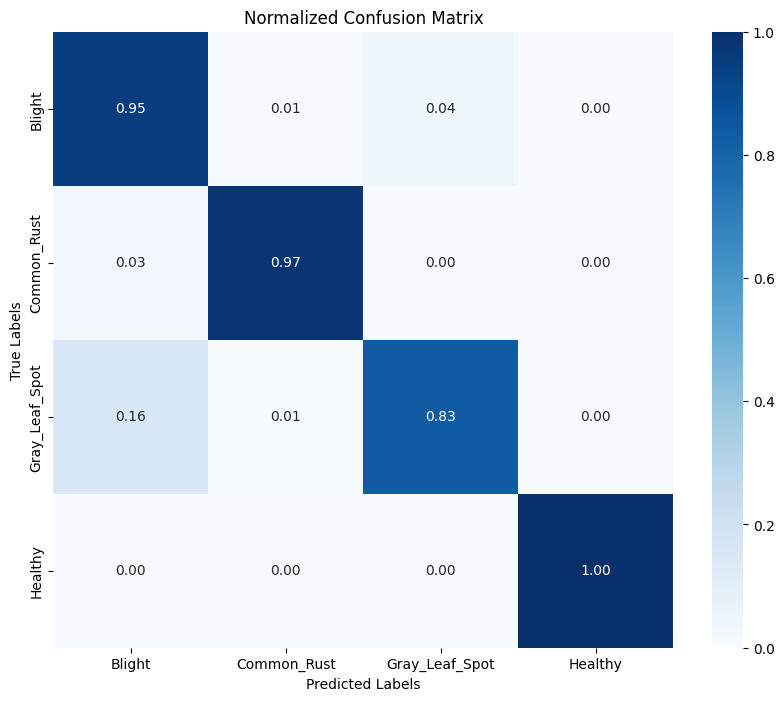

Classification Report:
                precision    recall  f1-score   support

        Blight       0.90      0.95      0.92       229
   Common_Rust       0.98      0.97      0.98       261
Gray_Leaf_Spot       0.91      0.83      0.87       115
       Healthy       1.00      1.00      1.00       233

      accuracy                           0.95       838
     macro avg       0.95      0.94      0.94       838
  weighted avg       0.96      0.95      0.95       838


Confusion Matrix:

[[217   3   9   0]
 [  7 254   0   0]
 [ 18   1  96   0]
 [  0   0   0 233]]


In [10]:
class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

# Confusion Matrix
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))